In [1]:
%load_ext autoreload
%autoreload 2
import os
import sys
import time

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import pykeen
import torch
from pykeen.pipeline import pipeline

In [2]:
dataset = 'Nations'
num_epochs = 1000
embedding_dim = 1
loss = 'BCEWithLogitsLoss'
margin = 1.0

In [4]:
ds = pykeen.datasets.get_dataset(dataset=dataset)

training = ds.training.mapped_triples
ds.training.mapped_triples = training[training[:,0].sort()[1]]
testing = ds.testing.mapped_triples
ds.testing.mapped_triples = testing[testing[:,0].sort()[1]]
validation = ds.validation.mapped_triples
ds.validation.mapped_triples = validation[validation[:,0].sort()[1]]

In [5]:
ds.training.mapped_triples[:20]

tensor([[ 0, 33,  9],
        [ 0, 38, 12],
        [ 0, 38, 11],
        [ 0, 38,  9],
        [ 0, 38,  7],
        [ 0, 38,  5],
        [ 0, 38,  3],
        [ 0, 37, 12],
        [ 0, 37, 11],
        [ 0, 37,  9],
        [ 0, 33, 13],
        [ 0, 33, 12],
        [ 0, 33, 11],
        [ 0, 33, 10],
        [ 0, 39,  5],
        [ 0, 33,  6],
        [ 0, 33,  5],
        [ 0, 33,  4],
        [ 0, 32, 12],
        [ 0, 32, 11]])

In [6]:
import functools
import itertools
from typing import Optional

from pykeen.models import StructuredEmbedding
from pykeen.models.base import EntityEmbeddingModel
from pykeen.nn import Embedding
from pykeen.losses import Loss
from pykeen.nn.init import xavier_uniform_
from pykeen.regularizers import Regularizer
from pykeen.triples import TriplesFactory
from pykeen.typing import DeviceHint
from pykeen.utils import compose

class ModifiedSE(StructuredEmbedding):
    
    def __init__(
        self,
        triples_factory: TriplesFactory,
        embedding_dim: int = 50,
        scoring_fct_norm: int = 2,
        loss: Optional[Loss] = None,
        preferred_device: DeviceHint = None,
        random_seed: Optional[int] = None,
        regularizer: Optional[Regularizer] = None,
    ) -> None:
        r"""Initialize SE.

        :param embedding_dim: The entity embedding dimension $d$. Is usually $d \in [50, 300]$.
        :param scoring_fct_norm: The $l_p$ norm. Usually 1 for SE.
        """
        super().__init__(
            triples_factory=triples_factory,
            embedding_dim=embedding_dim,
            loss=loss,
            preferred_device=preferred_device,
            random_seed=random_seed,
            regularizer=regularizer,
        )
            
    def score_hrt(self, hrt_batch: torch.LongTensor) -> torch.FloatTensor:  # noqa: D102
        # Get embeddings
        h = self.entity_embeddings(indices=hrt_batch[:, 0]).view(-1, self.embedding_dim, 1)
        rel_h = self.left_relation_embeddings(indices=hrt_batch[:, 1]).view(-1, self.embedding_dim, self.embedding_dim)
        rel_t = self.right_relation_embeddings(indices=hrt_batch[:, 1]).view(-1, self.embedding_dim, self.embedding_dim)
        t = self.entity_embeddings(indices=hrt_batch[:, 2]).view(-1, self.embedding_dim, 1)
        
        print(hrt_batch[:,1])
        print(torch.unique(rel_h, dim=))

        # Project entities
        proj_h = rel_h @ h
        proj_t = rel_t @ t
        
        norms = torch.norm(proj_h - proj_t, dim=1, p=self.scoring_fct_norm)**2
        scores = -norms
        return scores
    
    def score_t(self, hr_batch: torch.LongTensor, slice_size: int = None) -> torch.FloatTensor:  # noqa: D102
        # Get embeddings
        h = self.entity_embeddings(indices=hr_batch[:, 0]).view(-1, self.embedding_dim, 1)
        rel_h = self.left_relation_embeddings(indices=hr_batch[:, 1]).view(-1, self.embedding_dim, self.embedding_dim)
        rel_t = self.right_relation_embeddings(indices=hr_batch[:, 1])
        rel_t = rel_t.view(-1, 1, self.embedding_dim, self.embedding_dim)
        t_all = self.entity_embeddings(indices=None).view(1, -1, self.embedding_dim, 1)

        if slice_size is not None:
            proj_t_arr = []
            # Project entities
            proj_h = rel_h @ h

            for t in torch.split(t_all, slice_size, dim=1):
                # Project entities
                proj_t = rel_t @ t
                proj_t_arr.append(proj_t)

            proj_t = torch.cat(proj_t_arr, dim=1)

        else:
            # Project entities
            proj_h = rel_h @ h
            proj_t = rel_t @ t_all
            
        norms = torch.norm(proj_h[:, None, :, 0] - proj_t[:, :, :, 0], dim=-1, p=self.scoring_fct_norm)**2
        scores = -norms
        return scores


    def score_h(self, rt_batch: torch.LongTensor, slice_size: int = None) -> torch.FloatTensor:  # noqa: D102
        # Get embeddings
        h_all = self.entity_embeddings(indices=None).view(1, -1, self.embedding_dim, 1)
        rel_h = self.left_relation_embeddings(indices=rt_batch[:, 0])
        rel_h = rel_h.view(-1, 1, self.embedding_dim, self.embedding_dim)
        rel_t = self.right_relation_embeddings(indices=rt_batch[:, 0]).view(-1, self.embedding_dim, self.embedding_dim)
        t = self.entity_embeddings(indices=rt_batch[:, 1]).view(-1, self.embedding_dim, 1)

        if slice_size is not None:
            proj_h_arr = []

            # Project entities
            proj_t = rel_t @ t

            for h in torch.split(h_all, slice_size, dim=1):
                # Project entities
                proj_h = rel_h @ h
                proj_h_arr.append(proj_h)

            proj_h = torch.cat(proj_h_arr, dim=1)
        else:
            # Project entities
            proj_h = rel_h @ h_all
            proj_t = rel_t @ t

        norms = torch.norm(proj_h[:, :, :, 0] - proj_t[:, None, :, 0], dim=-1, p=self.scoring_fct_norm)**2
        scores = -norms
        return scores

In [6]:
result2 = pipeline(
    model=ModifiedSE,
    dataset=dataset,
    random_seed=1235,
    device='gpu',
    training_kwargs=dict(num_epochs=num_epochs, sampler='presorted'),
    model_kwargs=dict(embedding_dim=embedding_dim),
    loss=loss,
    loss_kwargs=dict(),
#     stopper='early',
#     stopper_kwargs=dict(frequency=10, patience=2, relative_delta=0.001, metric='mean_reciprocal_rank')
)
model2 = result2.model
model2

You're trying to map triples with 30 entities and 0 relations that are not in the training set. These triples will be excluded from the mapping.
In total 28 from 20466 triples were filtered out
You're trying to map triples with 9 entities and 0 relations that are not in the training set. These triples will be excluded from the mapping.
In total 9 from 17535 triples were filtered out


Not Shuffling!


INFO:pykeen.evaluation.evaluator:Starting batch_size search for evaluation now...


INFO:pykeen.evaluation.evaluator:Concluded batch_size search with batch_size=4096.


INFO:pykeen.evaluation.evaluator:Evaluation took 8.21s seconds


ModifiedSE(
  (loss): BCEWithLogitsLoss()
  (regularizer): NoRegularizer()
  (entity_embeddings): Embedding(
    (_embeddings): Embedding(14505, 1)
  )
  (left_relation_embeddings): Embedding(
    (_embeddings): Embedding(237, 1)
  )
  (right_relation_embeddings): Embedding(
    (_embeddings): Embedding(237, 1)
  )
)

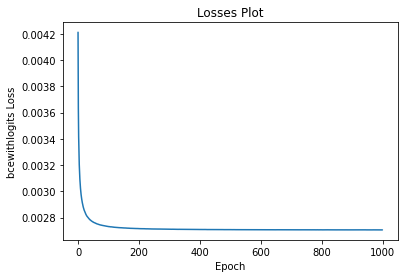

In [7]:
result2.plot_losses()
plt.show()

In [8]:
comp_models = ['StructuredEmbedding','TransE','RotatE','HolE']
comp_results = []
for comp_model in comp_models:
    print('Running {}'.format(comp_model))
    result = pipeline(
        dataset=dataset,
        model=comp_model,
        random_seed=1235,
        device='gpu',
        training_kwargs=dict(num_epochs=num_epochs),
        model_kwargs=dict(embedding_dim=embedding_dim),
        loss=loss,
        loss_kwargs=dict()
    )
    comp_results.append(result)

Running StructuredEmbedding


INFO:pykeen.evaluation.evaluator:Starting batch_size search for evaluation now...


INFO:pykeen.evaluation.evaluator:Concluded batch_size search with batch_size=4096.


INFO:pykeen.evaluation.evaluator:Evaluation took 8.19s seconds



Running TransE


INFO:pykeen.evaluation.evaluator:Starting batch_size search for evaluation now...


INFO:pykeen.evaluation.evaluator:Concluded batch_size search with batch_size=4096.


INFO:pykeen.evaluation.evaluator:Evaluation took 2.84s seconds



Running RotatE


INFO:pykeen.evaluation.evaluator:Starting batch_size search for evaluation now...


INFO:pykeen.evaluation.evaluator:Concluded batch_size search with batch_size=4096.


INFO:pykeen.evaluation.evaluator:Evaluation took 2.91s seconds



Running HolE


/home/gebhart/projects/pykeen/src/pykeen/models/unimodal/hole.py:102: UserWarning: The function torch.rfft is deprecated and will be removed in a future PyTorch release. Use the new torch.fft module functions, instead, by importing torch.fft and calling torch.fft.fft or torch.fft.rfft. (Triggered internally at  /pytorch/aten/src/ATen/native/SpectralOps.cpp:590.)
  a_fft = torch.rfft(h, signal_ndim=1, onesided=True)
/home/gebhart/projects/pykeen/src/pykeen/models/unimodal/hole.py:112: UserWarning: The function torch.irfft is deprecated and will be removed in a future PyTorch release. Use the new torch.fft module functions, instead, by importing torch.fft and calling torch.fft.ifft or torch.fft.irfft. (Triggered internally at  /pytorch/aten/src/ATen/native/SpectralOps.cpp:602.)
  composite = torch.irfft(p_fft, signal_ndim=1, onesided=True, signal_sizes=(h.shape[-1],))


INFO:pykeen.evaluation.evaluator:Starting batch_size search for evaluation now...
INFO:pykeen.evaluation.evaluator:Concluded batch_size search with batch_size=4096.


INFO:pykeen.evaluation.evaluator:Evaluation took 2.99s seconds


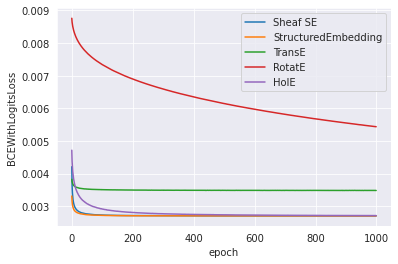

In [9]:
plt.plot(np.arange(len(result2.losses)),result2.losses,label='Sheaf SE')
for i in range(len(comp_models)):
    comp_model = comp_models[i]
    comp_result = comp_results[i]
    plt.plot(np.arange(len(comp_result.losses)),comp_result.losses,label=comp_model)
plt.ylabel(str(result.model.loss).replace('()',''))
plt.xlabel('epoch')
plt.legend()
plt.show()

In [10]:
res_df = result2.metric_results.to_df()

In [11]:
compto = 1

In [12]:
res_df['diff'] = res_df.Value - comp_results[compto].metric_results.to_df().Value
res_df

,Side,Type,Metric,Value,diff
0,tail,avg,adjusted_mean_rank,0.998091,5.225120e-02
1,head,avg,adjusted_mean_rank,0.998277,3.332248e-03
2,both,avg,adjusted_mean_rank,0.998184,2.779173e-02
3,tail,avg,mean_rank,7221.889764,3.785520e+02
4,tail,avg,mean_reciprocal_rank,0.000185,-9.649264e-06
5,tail,avg,hits_at_1,0.000000,0.000000e+00
6,tail,avg,hits_at_3,0.000000,0.000000e+00
7,tail,avg,hits_at_5,0.000000,0.000000e+00
8,tail,avg,hits_at_10,0.000000,0.000000e+00
9,tail,best,mean_rank,3603.890547,3.778250e+02


In [13]:
# comp_results[0].model.score_all_triples()

In [14]:
# model2.score_all_triples()